In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize
import sys
sys.path.append('../utils')

# Reload the module to get the latest changes
import importlib
if 'UCB_SW' in sys.modules:
    importlib.reload(sys.modules['UCB_SW'])

from UCB_SW import UCBSWAgent


In [ ]:
np.random.seed(42)  # For reproducibility
T = 10000          # total time horizon
Inventory_frac = 0.3 
W = int(np.sqrt(T))   # sliding window size
W = int(np.sqrt(T)*5) # adjust according to the plots
print(f"Sliding window size: {W}")
n_products = 3
B = T * Inventory_frac * n_products  # total inventory across all products
n_intervals = 10
prices_per_product = 7
prices = np.linspace(0.1, 0.9, prices_per_product)

print(prices)

Sliding window size: 500
[0.1        0.23333333 0.36666667 0.5        0.63333333 0.76666667
 0.9       ]


# Slightly Non Stationary Environment

### We will simulate a slightly non-stationary environment by partitioning the rounds into intervals. The distribution in each intervall will be costant and at each intervall the mean and standard deviation will be incremented by a quantity sampled from a distribution


In [ ]:
class NonStationaryEnvironment:
    def __init__(self, possible_prices, num_products, change_probability=0.01, mu_lim=(0.3,0.7), std_lim=(0.05,0.15), rng=None):
        """
        Initialize a non-stationary environment for pricing optimization.
        
        Args:
            possible_prices: Array of possible price points
            num_products: Number of products in the environment
            change_probability: Probability of parameter change at each timestep
            mu_lim: Tuple defining limits for mean valuations (min, max)
            std_lim: Tuple defining limits for standard deviations (min, max)
            rng: Random number generator instance
        """
        self.rng = rng if rng else np.random.default_rng()
        self.possible_prices = possible_prices
        self.num_products = num_products
        self.change_probability = change_probability
        self.mu_lim = mu_lim
        self.std_lim = std_lim

    def sample_parameters(self, T):
        """
        Sample mean and standard deviation parameters for each timestep.
        Creates piecewise constant distributions that change at random intervals.
        
        Args:
            T: Total number of timesteps
        """
        means_per_timestep = np.empty((T, self.num_products))
        stds_per_timestep = np.empty((T, self.num_products))

        # Determine when changes occur for each product at each timestep
        change_triggers = np.random.random(size=(T, self.num_products))
        change_mask = change_triggers < self.change_probability
        n_changes = np.sum(change_mask)
        
        # Sample initial parameters for each product
        starting_means = self.rng.uniform(low=self.mu_lim[0], high=self.mu_lim[1], size=self.num_products)
        starting_stds = self.rng.uniform(low=self.std_lim[0], high=self.std_lim[1], size=self.num_products)

        # Sample new parameters for all change events
        means = self.rng.uniform(low=self.mu_lim[0], high=self.mu_lim[1], size=n_changes)
        stds = self.rng.uniform(low=self.std_lim[0], high=self.std_lim[1], size=n_changes)

        # Get indices where changes occur
        change_timesteps, change_products = np.nonzero(change_mask)
        
        # Fill parameters for each product across all timesteps
        for product in range(self.num_products):
            product_mask = change_products == product
            if np.sum(product_mask) == 0:
                # No changes for this product - use starting values throughout
                means_per_timestep[:, product] = starting_means[product]
                stds_per_timestep[:, product] = starting_stds[product]
                continue
            
            # Get change points and new values for this product
            product_change_steps = change_timesteps[product_mask]
            product_means = means[product_mask]
            product_stds = stds[product_mask]
            
            # Fill initial period (before first change)
            means_per_timestep[:product_change_steps[0], product] = starting_means[product]
            stds_per_timestep[:product_change_steps[0], product] = starting_stds[product]
            
            # Fill periods between changes
            for i in range(len(product_change_steps) - 1):
                start_step = product_change_steps[i]
                end_step = product_change_steps[i+1]
                means_per_timestep[start_step:end_step, product] = product_means[i]
                stds_per_timestep[start_step:end_step, product] = product_stds[i]

            # Fill final period (after last change)
            means_per_timestep[product_change_steps[-1]:, product] = product_means[-1]
            stds_per_timestep[product_change_steps[-1]:, product] = product_stds[-1]
            
        # Store generated parameters
        self.means = means_per_timestep
        self.stds = stds_per_timestep

    def sample_valuation(self, t):
        """
        Sample customer valuations from normal distributions for timestep t.
        
        Args:
            t: Current timestep
            
        Returns:
            Clipped valuations in [0,1] range for current timestep only
        """
        # Sample valuations for current timestep only
        current_means = self.means[t]  # Shape: (num_products,)
        current_stds = self.stds[t]    # Shape: (num_products,)
        valuations = self.rng.normal(loc=current_means, scale=current_stds)
        return np.clip(valuations, 0, 1)

    def buyer_response(self, prices, valuations):
        """
        Determine buyer purchase decisions based on prices vs valuations.
        
        Args:
            prices: Array of prices for each product
            valuations: Array of customer valuations for each product
            
        Returns:
            Boolean array indicating purchases (True if valuation > price)
        """
        return (prices < valuations).astype(bool)

    def get_rewards(self, t, prices):
        """
        Get rewards for given prices at timestep t.
        
        Args:
            t: Current timestep
            prices: Array of prices for each product
            
        Returns:
            Array of rewards (price if purchased, 0 otherwise)
        """
        # Sample customer valuations for this timestep only
        valuations = self.sample_valuation(t)
        
        # Determine purchases and calculate rewards
        purchases = self.buyer_response(prices, valuations)
        rewards = prices * purchases
        
        return rewards

### Evolution of the mean and standard deviation during time

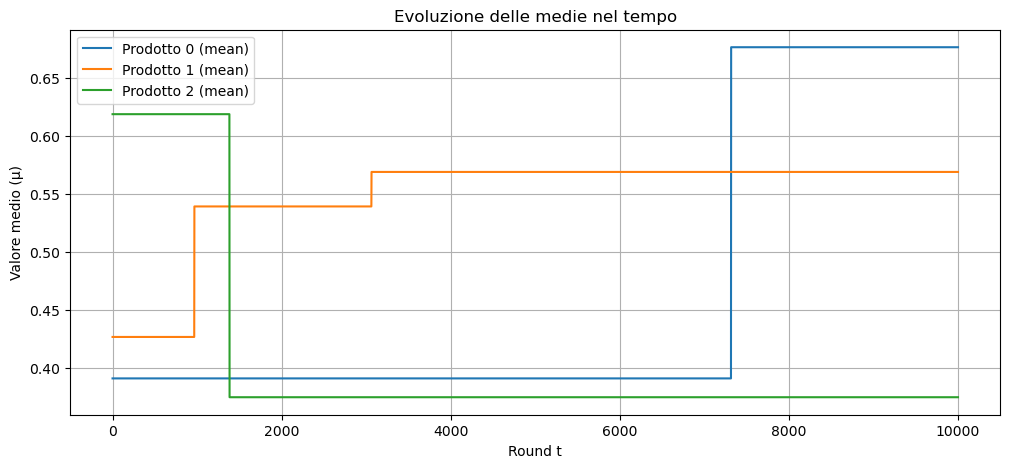

In [84]:
rng = np.random.default_rng(12345)
env = NonStationaryEnvironment(prices, n_products, change_probability=0.0001, rng=rng)
env.sample_parameters(T)

# Plot delle medie
plt.figure(figsize=(12,5))

for p in range(n_products):
    plt.plot(env.means[:, p], label=f"Prodotto {p} (mean)")

plt.title("Evoluzione delle medie nel tempo")
plt.xlabel("Round t")
plt.ylabel("Valore medio (μ)")
plt.legend()
plt.grid(True)
plt.show()


# Plot delle deviazioni standard
#plt.figure(figsize=(12,5))

#for p in range(n_products):
#    plt.plot(env.stds[p], label=f"Prodotto {p} (std)")

#plt.title("Evoluzione delle deviazioni standard nel tempo")
#plt.xlabel("Round t")
#plt.ylabel("Deviazione standard (σ)")
#plt.legend()
#plt.grid(True)
#plt.show()


Now we compare the performances of our learner with the baseline. The baseline knows the true expected reward of each arm

## Baseline

In [85]:
#Compute the revenue of the baseline strategy that knows the distribution of valuations
def baseline_revenue(env, B, T):
     
    K = len(env.possible_prices)

    #Reward for every product at each timestep
    reward_history = np.full((T, env.num_products), 0.0)

    optimal_gamma = optimal_policy(env, B, T)
    inventory = B

    for t in range(T):
        #print("Step ",t , " in the optimal policy")
        if inventory < env.num_products:
            print(f"Inventory deployed at step {t}")
            break
        arms = np.empty(env.num_products, dtype=int)
        for product in range(env.num_products):
            #For every product sample a price (the index)
            arms[product] = np.random.choice(K, p = optimal_gamma[product])
       
        #Price selected for each product
        prices = env.possible_prices[arms]

        #Reward for each product at time t: if valuation > price -> reward = price, else 0
        rewards = env.get_rewards(t, prices)

        #Inventory consumed
        inventory -= np.count_nonzero(rewards)

        reward_history[t] = rewards
    #Return the cumulative reward of each product overtime    
    return reward_history


#Compute the optimal policy knowing the true expected rewards and purchase probabilities
def optimal_policy(env, B, T):
    
    n = env.num_products
    K = len(env.possible_prices)

    #Compute true expected reward and demand probabilities for each product and price
    purchase_prob = np.zeros((T, n, K))

    for t in range(T):
         for i in range(n):
            for j in range(K):
                 #P(valuation > price) = 1 - CDF(price) for each product and for each timestep
                 purchase_prob[t,i,j] = 1 - norm.cdf(env.possible_prices[j], loc=env.means[t,i], scale=env.stds[t,i])

    #Compute the average purchase probability over time for each product and price
    avg_purchase_prob = purchase_prob.mean(axis=0)

    #Compute the expected reward for each product and price
    expected_rewards = np.zeros((n, K))
    for i in range(n):
         expected_rewards[i,:] = env.possible_prices * avg_purchase_prob[i,:]

    #Initialize the coefficient matrix for equality constraints
    A_eq = np.zeros((n, n*K))
    b_eq = np.ones(n)

    for dim in range(n):
        A_eq[dim,dim*K:(dim+1)*K] = 1

    c = -expected_rewards.flatten()
    A_ub = [avg_purchase_prob.flatten()]
    b_ub = [B/T]
    

    # Solve linear program
    try:
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq = b_eq,
                                bounds=(0,1))
        if res.success:
            gamma_flat = res.x
            # Reshape gamma back to (n_products, n_price_options)
            gamma = gamma_flat.reshape((n, K))

            # Ensure valid probability distribution for each product
            for product_idx in range(n):
                gamma[product_idx, :] = np.maximum(gamma[product_idx, :], 0)
                sum_gamma = np.sum(gamma[product_idx, :])
                if sum_gamma > 0:
                        gamma[product_idx, :] /= sum_gamma
                else:
                        # Fallback: uniform distribution for this product
                        gamma[product_idx, :] = np.ones(K) / K

            return gamma
        else:
            # Fallback: uniform distribution for all products
            return np.ones((n, K)) / K
    except Exception as e:
        print(f"LP Error: {e}")
        # Fallback: uniform distribution for all products
        return np.ones((n, K)) / K



## Initialize the enviroment and Run a simulation

In [86]:
# Initialize the environment
rng = np.random.default_rng(42)
env = NonStationaryEnvironment(prices, n_products, change_probability=0.001, rng=rng)
env.sample_parameters(T)

# Initialize the agent with improved inventory management
agent = UCBSWAgent(
    n_products=n_products, 
    price_options=prices, 
    inventory=B, 
    T=T, 
    window_size=W,
)

# total_reward = 0
reward_history = np.zeros((T, env.num_products))
inventory_consumed = 0

for t in range(T):

    if t % (T//10) == 0:
        print(f"Time step: {t}, Remaining inventory: {agent.remaining_inventory}")

    # Agent selects a price for each product - returns (product_subset, prices)
    product_subset, selected_prices = agent.select_action()
    if len(product_subset) == 0:
        print(f"Not enough inventory left at time step {t}")
        print(f"Total inventory consumed: {inventory_consumed}")
        break

    # Create full price vector for all products
    price = np.zeros(env.num_products)
    price[product_subset] = selected_prices

    # Vector of the rewards of the arm
    f_t = env.get_rewards(t, price)
    
    # Vector of the cost of the arm
    c_t = (f_t != 0).astype(int)
    inventory_consumed += np.sum(c_t)
    reward_history[t] = f_t
    agent.update(f_t, c_t)

print(f"Simulation completed. Total inventory consumed: {inventory_consumed}")

# Cumulative reward of each product over time
agent_cumulative_reward = reward_history.cumsum(axis=0)

# Reward history of the baseline
baseline_reward_history = baseline_revenue(env, B, T)
baseline_cumulative_reward = baseline_reward_history.cumsum(axis=0)

print(f"Agent total reward: {agent_cumulative_reward[-1].sum():.2f}")
print(f"Baseline total reward: {baseline_cumulative_reward[-1].sum():.2f}")
print(f"Performance ratio: {agent_cumulative_reward[-1].sum() / baseline_cumulative_reward[-1].sum():.3f}")
print(f"Inventory utilization: {inventory_consumed / B:.3f}")


Time step: 0, Remaining inventory: 9000.0
Time step: 1000, Remaining inventory: 7278.0
Time step: 2000, Remaining inventory: 6342.0
Time step: 3000, Remaining inventory: 4969.0
Time step: 4000, Remaining inventory: 3914.0
Time step: 5000, Remaining inventory: 3046.0
Time step: 6000, Remaining inventory: 2023.0
Time step: 7000, Remaining inventory: 1224.0
Time step: 8000, Remaining inventory: 478.0
Time step: 9000, Remaining inventory: 33.0
Not enough inventory left at time step 9223
Total inventory consumed: 9000
Simulation completed. Total inventory consumed: 9000
Agent total reward: 4616.80
Baseline total reward: 5136.47
Performance ratio: 0.899
Inventory utilization: 1.000


# Plot of the cumulative rewards and regret

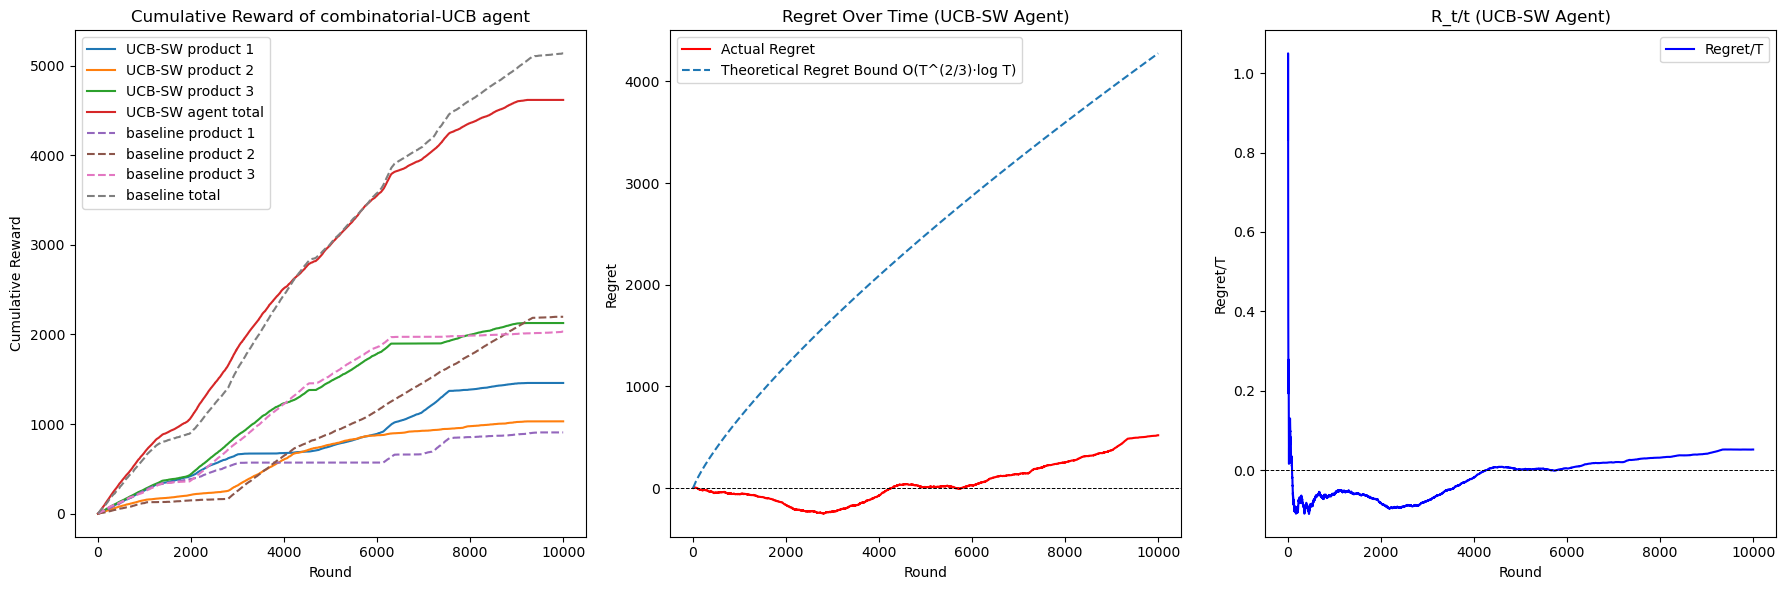

Final regret: 519.67
Theoretical bound at T: 4275.06
Regret/Theoretical ratio: 0.12


In [87]:
# Regret at each time step
regret = (baseline_cumulative_reward - agent_cumulative_reward).sum(axis=1)

# More appropriate theoretical bound for sliding window UCB with non-stationarity
theoretical_regret = [(t + 1)**(2/3) * np.log(t + 1) for t in range(len(regret))]

# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(agent_cumulative_reward)
plt.plot(agent_cumulative_reward.sum(axis=1))
plt.plot(baseline_cumulative_reward, linestyle="--")
plt.plot(baseline_cumulative_reward.sum(axis=1), linestyle="--")
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward of combinatorial-UCB agent")
plt.legend(["UCB-SW product 1", "UCB-SW product 2", "UCB-SW product 3", "UCB-SW agent total", "baseline product 1", "baseline product 2", "baseline product 3", "baseline total"])

plt.subplot(1, 3, 2)
plt.plot(regret, label="Actual Regret", color='red')
plt.plot(theoretical_regret, label="Theoretical Regret Bound O(T^(2/3)·log T)", linestyle="--")
plt.axhline(0, color='black', linestyle='--',linewidth=0.7)
plt.xlabel("Round")
plt.ylabel("Regret")
plt.title("Regret Over Time (UCB-SW Agent)")
plt.legend()

plt.subplot(1, 3, 3)
t_vals = np.arange(len(regret)) + 1  # Avoid division by zero
plt.plot(regret/t_vals, label="Regret/T", color='blue')
plt.axhline(0, color='black', linestyle='--',linewidth=0.7)
plt.xlabel("Round")
plt.ylabel("Regret/T")
plt.title("R_t/t (UCB-SW Agent)")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final regret: {regret[-1]:.2f}")
print(f"Theoretical bound at T: {theoretical_regret[-1]:.2f}")
print(f"Regret/Theoretical ratio: {regret[-1]/theoretical_regret[-1]:.2f}")


# Comparison Combinatorial UCB vs UCB-SW

In [88]:
import sys
sys.path.append('../utils')

# Import UCB_multi_constr
from UCB1_multi_constr import UCBMatchingAgent

def run_simulation(agent_class, agent_params, env, T, B, description="Agent"):
    """
    Run a simulation with a specific agent and return the results.
    
    Args:
        agent_class: The agent class to instantiate
        agent_params: Dictionary of parameters for the agent
        env: The environment instance
        T: Time horizon
        B: Total inventory
        description: Description for logging
    
    Returns:
        Dictionary with simulation results
    """
    print(f"\n--- Running simulation with {description} ---")
    
    # Initialize agent
    agent = agent_class(**agent_params)
    
    # Track results
    reward_history = np.zeros((T, env.num_products))
    inventory_consumed = 0
    
    for t in range(T):
        if t % (T//10) == 0:
            print(f"Time step: {t}, Remaining inventory: {agent.remaining_inventory}")
        
        # Agent selects action based on its interface
        if hasattr(agent, 'select_action') and 'UCBSWAgent' in str(type(agent)):  # UCB_SW interface
            product_subset, selected_prices = agent.select_action()
            if len(product_subset) == 0:
                print(f"Not enough inventory left at time step {t}")
                break
            
            # Create full price vector for all products
            prices = np.zeros(env.num_products)
            prices[product_subset] = selected_prices
            
            rewards = env.get_rewards(t, prices)
            costs = (rewards != 0).astype(int)
            
            inventory_consumed += np.sum(costs)
            reward_history[t] = rewards
            agent.update(rewards, costs)
            
        elif hasattr(agent, 'select_action'):  # UCB_multi_constr interface
            product_subset, prices = agent.select_action()
            if len(product_subset) == 0:
                print(f"Not enough inventory left at time step {t}")
                break
            
            # Get rewards for selected products
            full_prices = np.zeros(env.num_products)
            full_prices[product_subset] = prices
            
            full_rewards = env.get_rewards(t, full_prices)
            
            # Only consider rewards for selected products
            rewards = full_rewards[product_subset]
            products_purchased = [i for i, product_idx in enumerate(product_subset) if full_rewards[product_idx] > 0]
            
            # Convert to product indices that were actually purchased
            actual_purchased_products = [product_subset[i] for i in products_purchased]
            
            inventory_consumed += len(actual_purchased_products)
            reward_history[t] = full_rewards  # Store full reward vector
            
            agent.update(actual_purchased_products, np.sum(rewards))
    
    print(f"Simulation completed. Total inventory consumed: {inventory_consumed}")
    
    return {
        'reward_history': reward_history,
        'cumulative_reward': reward_history.cumsum(axis=0),
        'inventory_consumed': inventory_consumed,
        'agent': agent,
        'description': description
    }

# Simulation parameters
np.random.seed(42)  # For reproducibility

# Create fresh environment for comparison
rng = np.random.default_rng(12345)
env_comparison = NonStationaryEnvironment(prices, n_products, change_probability=0.001, rng=rng)
env_comparison.sample_parameters(T)

# Parameters for UCB-SW
ucb_sw_params = {
    'n_products': n_products,
    'price_options': prices,
    'inventory': B,
    'T': T,
    'window_size': W
}

# Parameters for UCB_multi_constr
ucb_multi_params = {
    'n_products': n_products,
    'price_options': prices,
    'inventory': B,
    'T': T,
    'selection_method': 'lsa'  # Use Linear Sum Assignment
}

# Run simulations
results_ucb_sw = run_simulation(UCBSWAgent, ucb_sw_params, env_comparison, T, B, "UCB-SW")
results_ucb_multi = run_simulation(UCBMatchingAgent, ucb_multi_params, env_comparison, T, B, "UCB Multi-Constraint")

# Get baseline results (reuse from previous simulation)
baseline_reward_history_comp = baseline_revenue(env_comparison, B, T)
baseline_cumulative_reward_comp = baseline_reward_history_comp.cumsum(axis=0)

print(f"\n--- Performance Comparison ---")
print(f"UCB-SW total reward: {results_ucb_sw['cumulative_reward'][-1].sum():.2f}")
print(f"UCB Multi-Constraint total reward: {results_ucb_multi['cumulative_reward'][-1].sum():.2f}")
print(f"Baseline total reward: {baseline_cumulative_reward_comp[-1].sum():.2f}")
print(f"UCB-SW performance ratio: {results_ucb_sw['cumulative_reward'][-1].sum() / baseline_cumulative_reward_comp[-1].sum():.3f}")
print(f"UCB Multi-Constraint performance ratio: {results_ucb_multi['cumulative_reward'][-1].sum() / baseline_cumulative_reward_comp[-1].sum():.3f}")
print(f"UCB-SW inventory utilization: {results_ucb_sw['inventory_consumed'] / B:.3f}")
print(f"UCB Multi-Constraint inventory utilization: {results_ucb_multi['inventory_consumed'] / B:.3f}")


--- Running simulation with UCB-SW ---
Time step: 0, Remaining inventory: 9000.0
Time step: 1000, Remaining inventory: 7328.0
Time step: 2000, Remaining inventory: 5684.0
Time step: 3000, Remaining inventory: 4930.0
Time step: 4000, Remaining inventory: 4287.0
Time step: 5000, Remaining inventory: 3054.0
Time step: 6000, Remaining inventory: 2141.0
Time step: 7000, Remaining inventory: 909.0
Time step: 8000, Remaining inventory: 21.0
Not enough inventory left at time step 8078
Simulation completed. Total inventory consumed: 9000

--- Running simulation with UCB Multi-Constraint ---
Time step: 0, Remaining inventory: 9000.0
Time step: 1000, Remaining inventory: 7152.0
Time step: 2000, Remaining inventory: 4834.0
Time step: 3000, Remaining inventory: 3353.0
Time step: 4000, Remaining inventory: 2493.0
Time step: 5000, Remaining inventory: 1984.0
Time step: 6000, Remaining inventory: 1386.0
Time step: 7000, Remaining inventory: 411.0
Not enough inventory left at time step 7503
Simulation

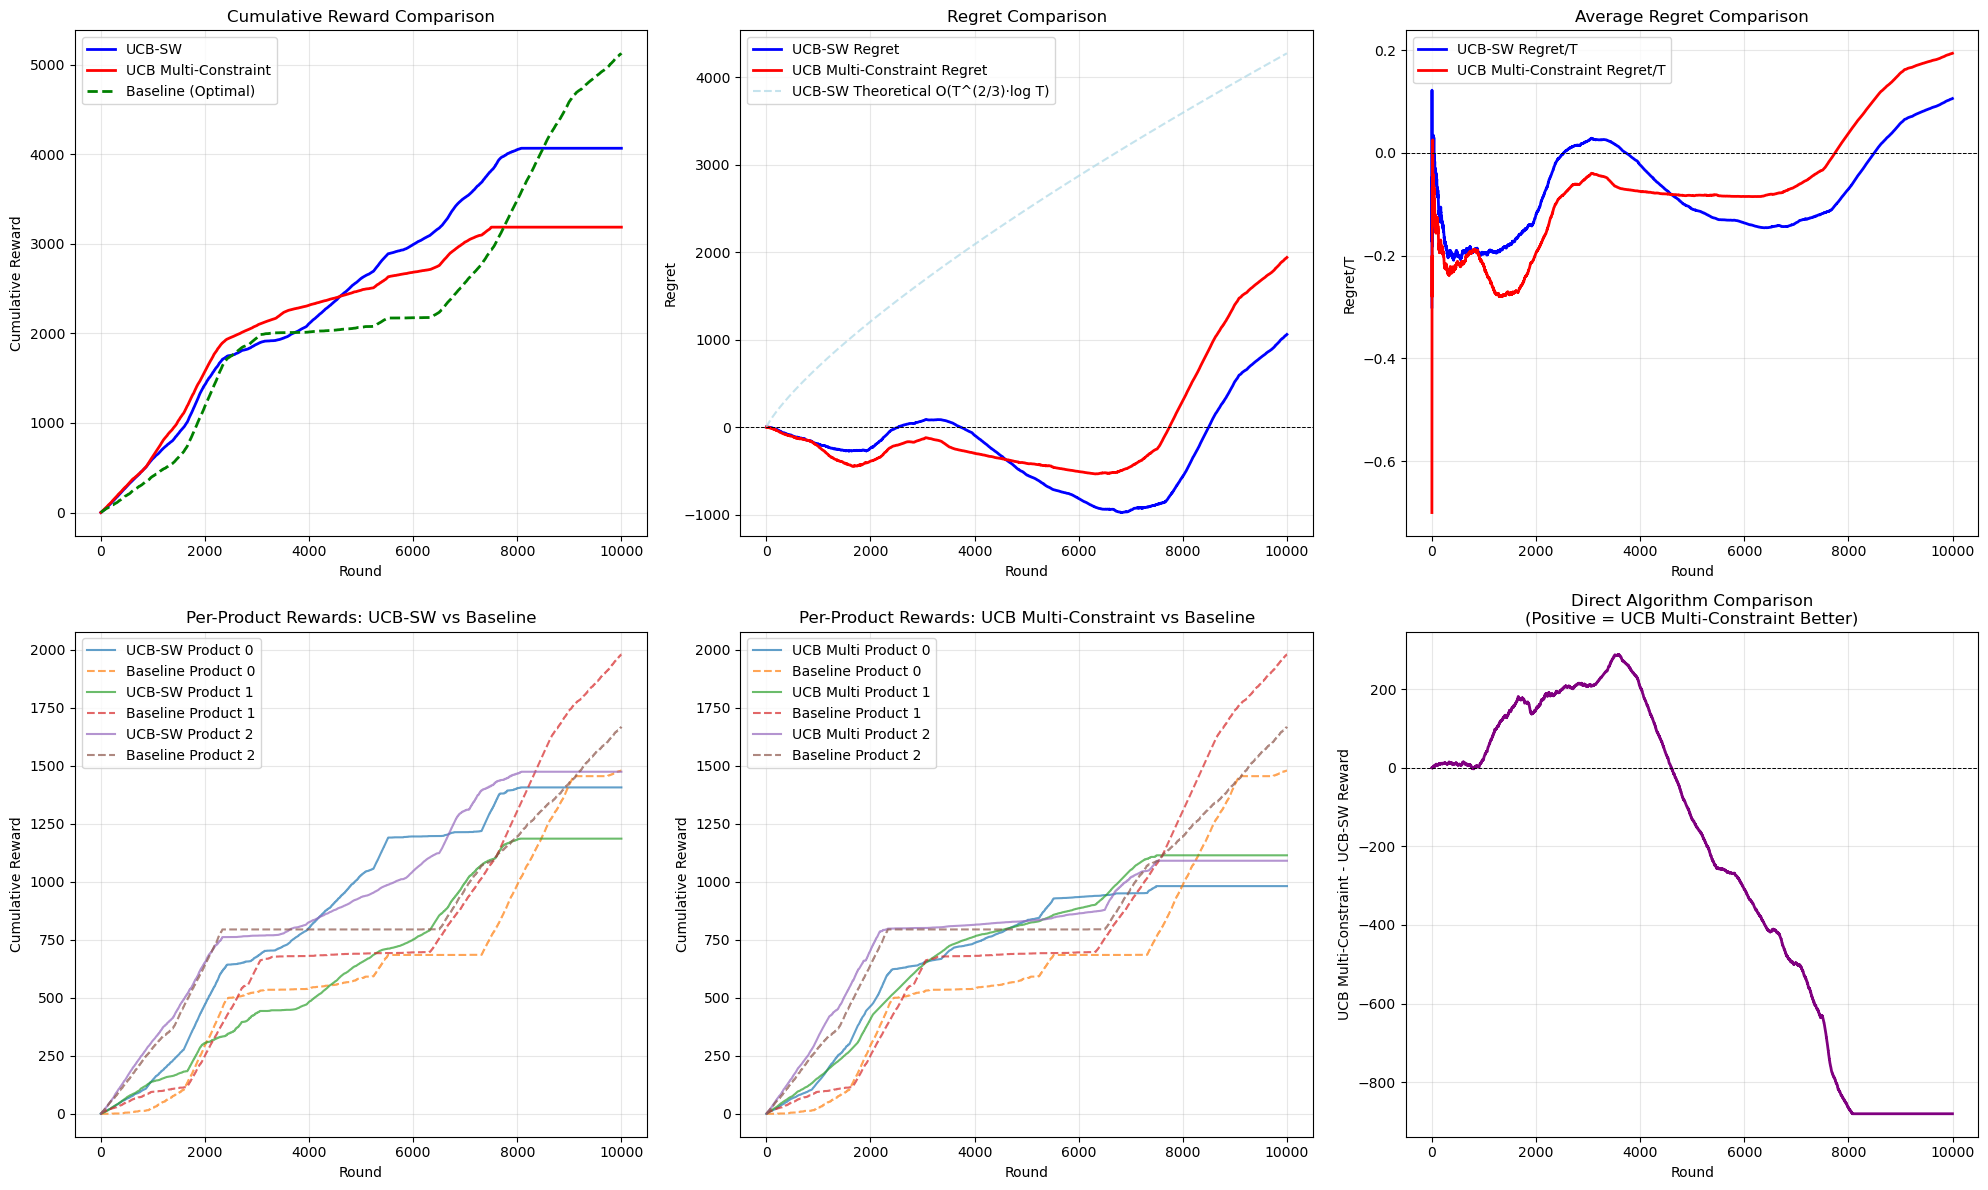


--- Detailed Performance Analysis ---
Final Regret:
  UCB-SW: 1059.77
  UCB Multi-Constraint: 1940.30
  Difference: 880.53

Final Regret/T:
  UCB-SW: 0.1060
  UCB Multi-Constraint: 0.1940

Theoretical vs Actual Regret Ratios:
  UCB-SW: 0.248
  UCB Multi-Constraint: 6.393

Total Revenue Difference: -880.53
Percentage Improvement: -21.66%


In [89]:
# Compute regrets for both algorithms
regret_ucb_sw = (baseline_cumulative_reward_comp - results_ucb_sw['cumulative_reward']).sum(axis=1)
regret_ucb_multi = (baseline_cumulative_reward_comp - results_ucb_multi['cumulative_reward']).sum(axis=1)

# Theoretical regret bounds
theoretical_regret_ucb_sw = [(t + 1)**(2/3) * np.log(t + 1) for t in range(len(regret_ucb_sw))]
theoretical_regret_ucb_multi = [np.sqrt((t + 1) * np.log(t + 1)) for t in range(len(regret_ucb_multi))]

# Create comprehensive comparison plots
plt.figure(figsize=(20, 12))

# Plot 1: Cumulative Rewards Comparison
plt.subplot(2, 3, 1)
plt.plot(results_ucb_sw['cumulative_reward'].sum(axis=1), label='UCB-SW', linewidth=2, color='blue')
plt.plot(results_ucb_multi['cumulative_reward'].sum(axis=1), label='UCB Multi-Constraint', linewidth=2, color='red')
plt.plot(baseline_cumulative_reward_comp.sum(axis=1), label='Baseline (Optimal)', linestyle='--', linewidth=2, color='green')
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Regret Comparison
plt.subplot(2, 3, 2)
plt.plot(regret_ucb_sw, label='UCB-SW Regret', linewidth=2, color='blue')
plt.plot(regret_ucb_multi, label='UCB Multi-Constraint Regret', linewidth=2, color='red')
plt.plot(theoretical_regret_ucb_sw, label='UCB-SW Theoretical O(T^(2/3)·log T)', linestyle='--', alpha=0.7, color='lightblue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Round')
plt.ylabel('Regret')
plt.title('Regret Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Regret/T Comparison
plt.subplot(2, 3, 3)
t_vals = np.arange(len(regret_ucb_sw)) + 1
plt.plot(regret_ucb_sw/t_vals, label='UCB-SW Regret/T', linewidth=2, color='blue')
plt.plot(regret_ucb_multi/t_vals, label='UCB Multi-Constraint Regret/T', linewidth=2, color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Round')
plt.ylabel('Regret/T')
plt.title('Average Regret Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Per-Product Cumulative Rewards (UCB-SW)
plt.subplot(2, 3, 4)
for i in range(n_products):
    plt.plot(results_ucb_sw['cumulative_reward'][:, i], label=f'UCB-SW Product {i}', alpha=0.7)
    plt.plot(baseline_cumulative_reward_comp[:, i], label=f'Baseline Product {i}', linestyle='--', alpha=0.7)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Per-Product Rewards: UCB-SW vs Baseline')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Per-Product Cumulative Rewards (UCB Multi-Constraint)
plt.subplot(2, 3, 5)
for i in range(n_products):
    plt.plot(results_ucb_multi['cumulative_reward'][:, i], label=f'UCB Multi Product {i}', alpha=0.7)
    plt.plot(baseline_cumulative_reward_comp[:, i], label=f'Baseline Product {i}', linestyle='--', alpha=0.7)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Per-Product Rewards: UCB Multi-Constraint vs Baseline')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Direct Algorithm Comparison
plt.subplot(2, 3, 6)
# Difference in cumulative rewards
reward_difference = results_ucb_multi['cumulative_reward'].sum(axis=1) - results_ucb_sw['cumulative_reward'].sum(axis=1)
plt.plot(reward_difference, linewidth=2, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Round')
plt.ylabel('UCB Multi-Constraint - UCB-SW Reward')
plt.title('Direct Algorithm Comparison\n(Positive = UCB Multi-Constraint Better)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison statistics
print(f"\n--- Detailed Performance Analysis ---")
print(f"Final Regret:")
print(f"  UCB-SW: {regret_ucb_sw[-1]:.2f}")
print(f"  UCB Multi-Constraint: {regret_ucb_multi[-1]:.2f}")
print(f"  Difference: {regret_ucb_multi[-1] - regret_ucb_sw[-1]:.2f}")

print(f"\nFinal Regret/T:")
print(f"  UCB-SW: {regret_ucb_sw[-1]/T:.4f}")
print(f"  UCB Multi-Constraint: {regret_ucb_multi[-1]/T:.4f}")

print(f"\nTheoretical vs Actual Regret Ratios:")
print(f"  UCB-SW: {regret_ucb_sw[-1]/theoretical_regret_ucb_sw[-1]:.3f}")
print(f"  UCB Multi-Constraint: {regret_ucb_multi[-1]/theoretical_regret_ucb_multi[-1]:.3f}")

print(f"\nTotal Revenue Difference: {results_ucb_multi['cumulative_reward'][-1].sum() - results_ucb_sw['cumulative_reward'][-1].sum():.2f}")
print(f"Percentage Improvement: {((results_ucb_multi['cumulative_reward'][-1].sum() - results_ucb_sw['cumulative_reward'][-1].sum()) / results_ucb_sw['cumulative_reward'][-1].sum() * 100):.2f}%")